What is Style ALAE?
StyleALAE uses the StyleGAN based generator along with the Adversarial Latent Autoencoder.StyleALAE can not only generate 1024×1024 face images with comparable quality of StyleGAN, but at the same resolution can also produce face reconstructions and manipulations based on real im-ages. This makes ALAE the first autoencoder able to compare with, and go beyond the capabilities of a generator-only type of architecture.style alae

Implementation
In this project, I have used usual 256x256 anime faces, instead of using 1204x1024 HD celebrity/human faces. First of all, it needs a lot of computation power and time to iterate over such high-resolution images, and secondly, I decided to choose a new theme fo this project which is not discussed in the research paper, so I chose anime faces over human faces.
And actually, the task was not so easy as I thought. while blending anime faces, generating the lip part in the generated anime face was the most difficult part, not only that coordinating the eyes in the generated face was also a tedious job. It involved a proper selection of data and hyperparameter tuning. A slight change in adjustment of learning rate or epsilon of Adam optimizer changed the entire quality of the generated image.

In [1]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip install tensorflow-addons
!pip install --upgrade --ignore-installed tensorflow

/bin/bash: line 1: /opt/conda/bin/python3.7: No such file or directory
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.7 MB/s eta 0:00:00
  Obtaining dependency information for h5py>=2.9.0 from https://files.pythonhosted.org/packages/3b/d3/ecb4b3d2ec2c84132987e5f12ab1408f455bec1d90cd5bc408ebf37800f5/h5py-3.10.

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
import logging

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import random
import sys

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
logging.disable(sys.maxsize)

In [5]:
BUFFER_SIZE=10
BATCH_SIZE=1
IMG_WIDTH=256
IMG_HEIGHT=256
OUTPUT_CHANNELS=3
EPOCHS=1705
LAMBDA=10
GAMMA=10
noise_dim=100

In [6]:
train_selfie_path = '../input/selfie2anime/testB'


In [7]:
train_selfie_imgs=np.array(sorted(os.listdir(train_selfie_path)))

In [8]:
train_selfie1_imgs = list(train_selfie_imgs[[0,52,19,54,39,71]])
train_selfie2_imgs = list(train_selfie_imgs[[4,43,55,45,31,23]])

In [9]:
ImageSet_1=[(train_selfie_path)+'/%s'%(x) for x in train_selfie1_imgs]
ImageSet_2=[(train_selfie_path)+'/%s'%(x) for x in train_selfie2_imgs]

In [10]:
def load(image_file):
    image=tf.io.read_file(image_file)
    image=tf.image.decode_jpeg(image)
    image_=tf.cast(image, tf.float32)
    return image_

In [11]:
def resize(input_, height, width):
    img_=tf.image.resize(input_,[height,width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img_

In [12]:
def normalize(input_):
    image=tf.cast(input_, tf.float32)
    img_=(image/127.5)-1
    return img_

In [13]:
@tf.function()
def random_jitter(input_):
    img_=resize(input_, IMG_HEIGHT, IMG_WIDTH)
    if tf.random.uniform(())>0.5:
        img_=tf.image.flip_left_right(img_)
    return img_

In [14]:
def load_image_train(file_):
    input_=load(file_)
    img_=random_jitter(input_)
    img_=normalize(img_)
    return img_

In [15]:
train_source=(
tf.data.Dataset.from_tensor_slices((ImageSet_1)).map(load_image_train, num_parallel_calls=AUTOTUNE).
    shuffle(7).batch(BATCH_SIZE)

)
train_dest=(
tf.data.Dataset.from_tensor_slices((ImageSet_2)).map(load_image_train, num_parallel_calls=AUTOTUNE).shuffle(7).batch(BATCH_SIZE)
)

In [16]:
def noise_(num, filter, noise):
    noise_layer=tf.keras.layers.Dense(num*num*filter)(noise)
    reshape_noise=tf.keras.layers.Reshape((num,num, filter))(noise_layer)
    return reshape_noise

In [21]:
def downsample(filters, size, stride, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
              tf.keras.layers.Conv2D(
                  filters, 
                  size, 
                  strides=stride, 
                  padding='same',
                  kernel_initializer=initializer, 
                  use_bias=False)
    )
    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU(0.4))
    
    return result

In [22]:
def upsample(filters, size, stride):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    layer = tf.keras.layers.Conv2DTranspose(
            filters, 
            size, 
            strides=stride,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False)
    
    result.add(
        layer
    )
    return result

In [23]:
def Generator():
    input_encoder = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH,3])
    input_generator = tf.keras.layers.Input(shape=[noise_dim, ])
    initializer = tf.random_normal_initializer(0., 0.02)

    down_stack = [
        #downsample(32, 3, 2, apply_batchnorm=False),
        downsample(64, 3, 2,False),
        downsample(128, 3, 2),
        downsample(256, 3, 2,False),
        downsample(512, 3, 2,),
        downsample(512, 3, 2,),
        downsample(512, 3, 2,False),
     ]
    x = input_encoder
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
  
    skips = reversed(skips[:-1])
    gen_layer = tf.keras.layers.Dense(4*4*512)(input_generator)
    gen_layer = tf.keras.layers.BatchNormalization()(gen_layer)
    gen_layer = tf.keras.layers.LeakyReLU(0.4)(gen_layer)

    reshape = tf.keras.layers.Reshape((4, 4, 512))(gen_layer)
    x = reshape
    up_stack = [
              upsample(512, 3, 2, ),
              upsample(512, 3, 2, ),
              upsample(256, 3, 2, ),
              upsample(128, 3, 2, ),
              upsample(64, 3, 2, ), 
      
   ]

    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh') 
    filters = [512,512,256,128,64]
    ndim = [8,16,32,64,128]
    for up, skip, dim, filt in zip(up_stack, skips, ndim, filters):
        x = up(x)
        n = noise_(dim, filt, input_generator)
        x = tf.keras.layers.concatenate([n, x])
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x = tf.keras.layers.concatenate([x, skip])
    
    x = last(x)
    return tf.keras.Model(inputs=[input_encoder,input_generator], outputs=x)

In [24]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 8192)                 827392    ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 8192)                 32768     ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)   (None, 8192)                 0         ['batch_normalization[0][0

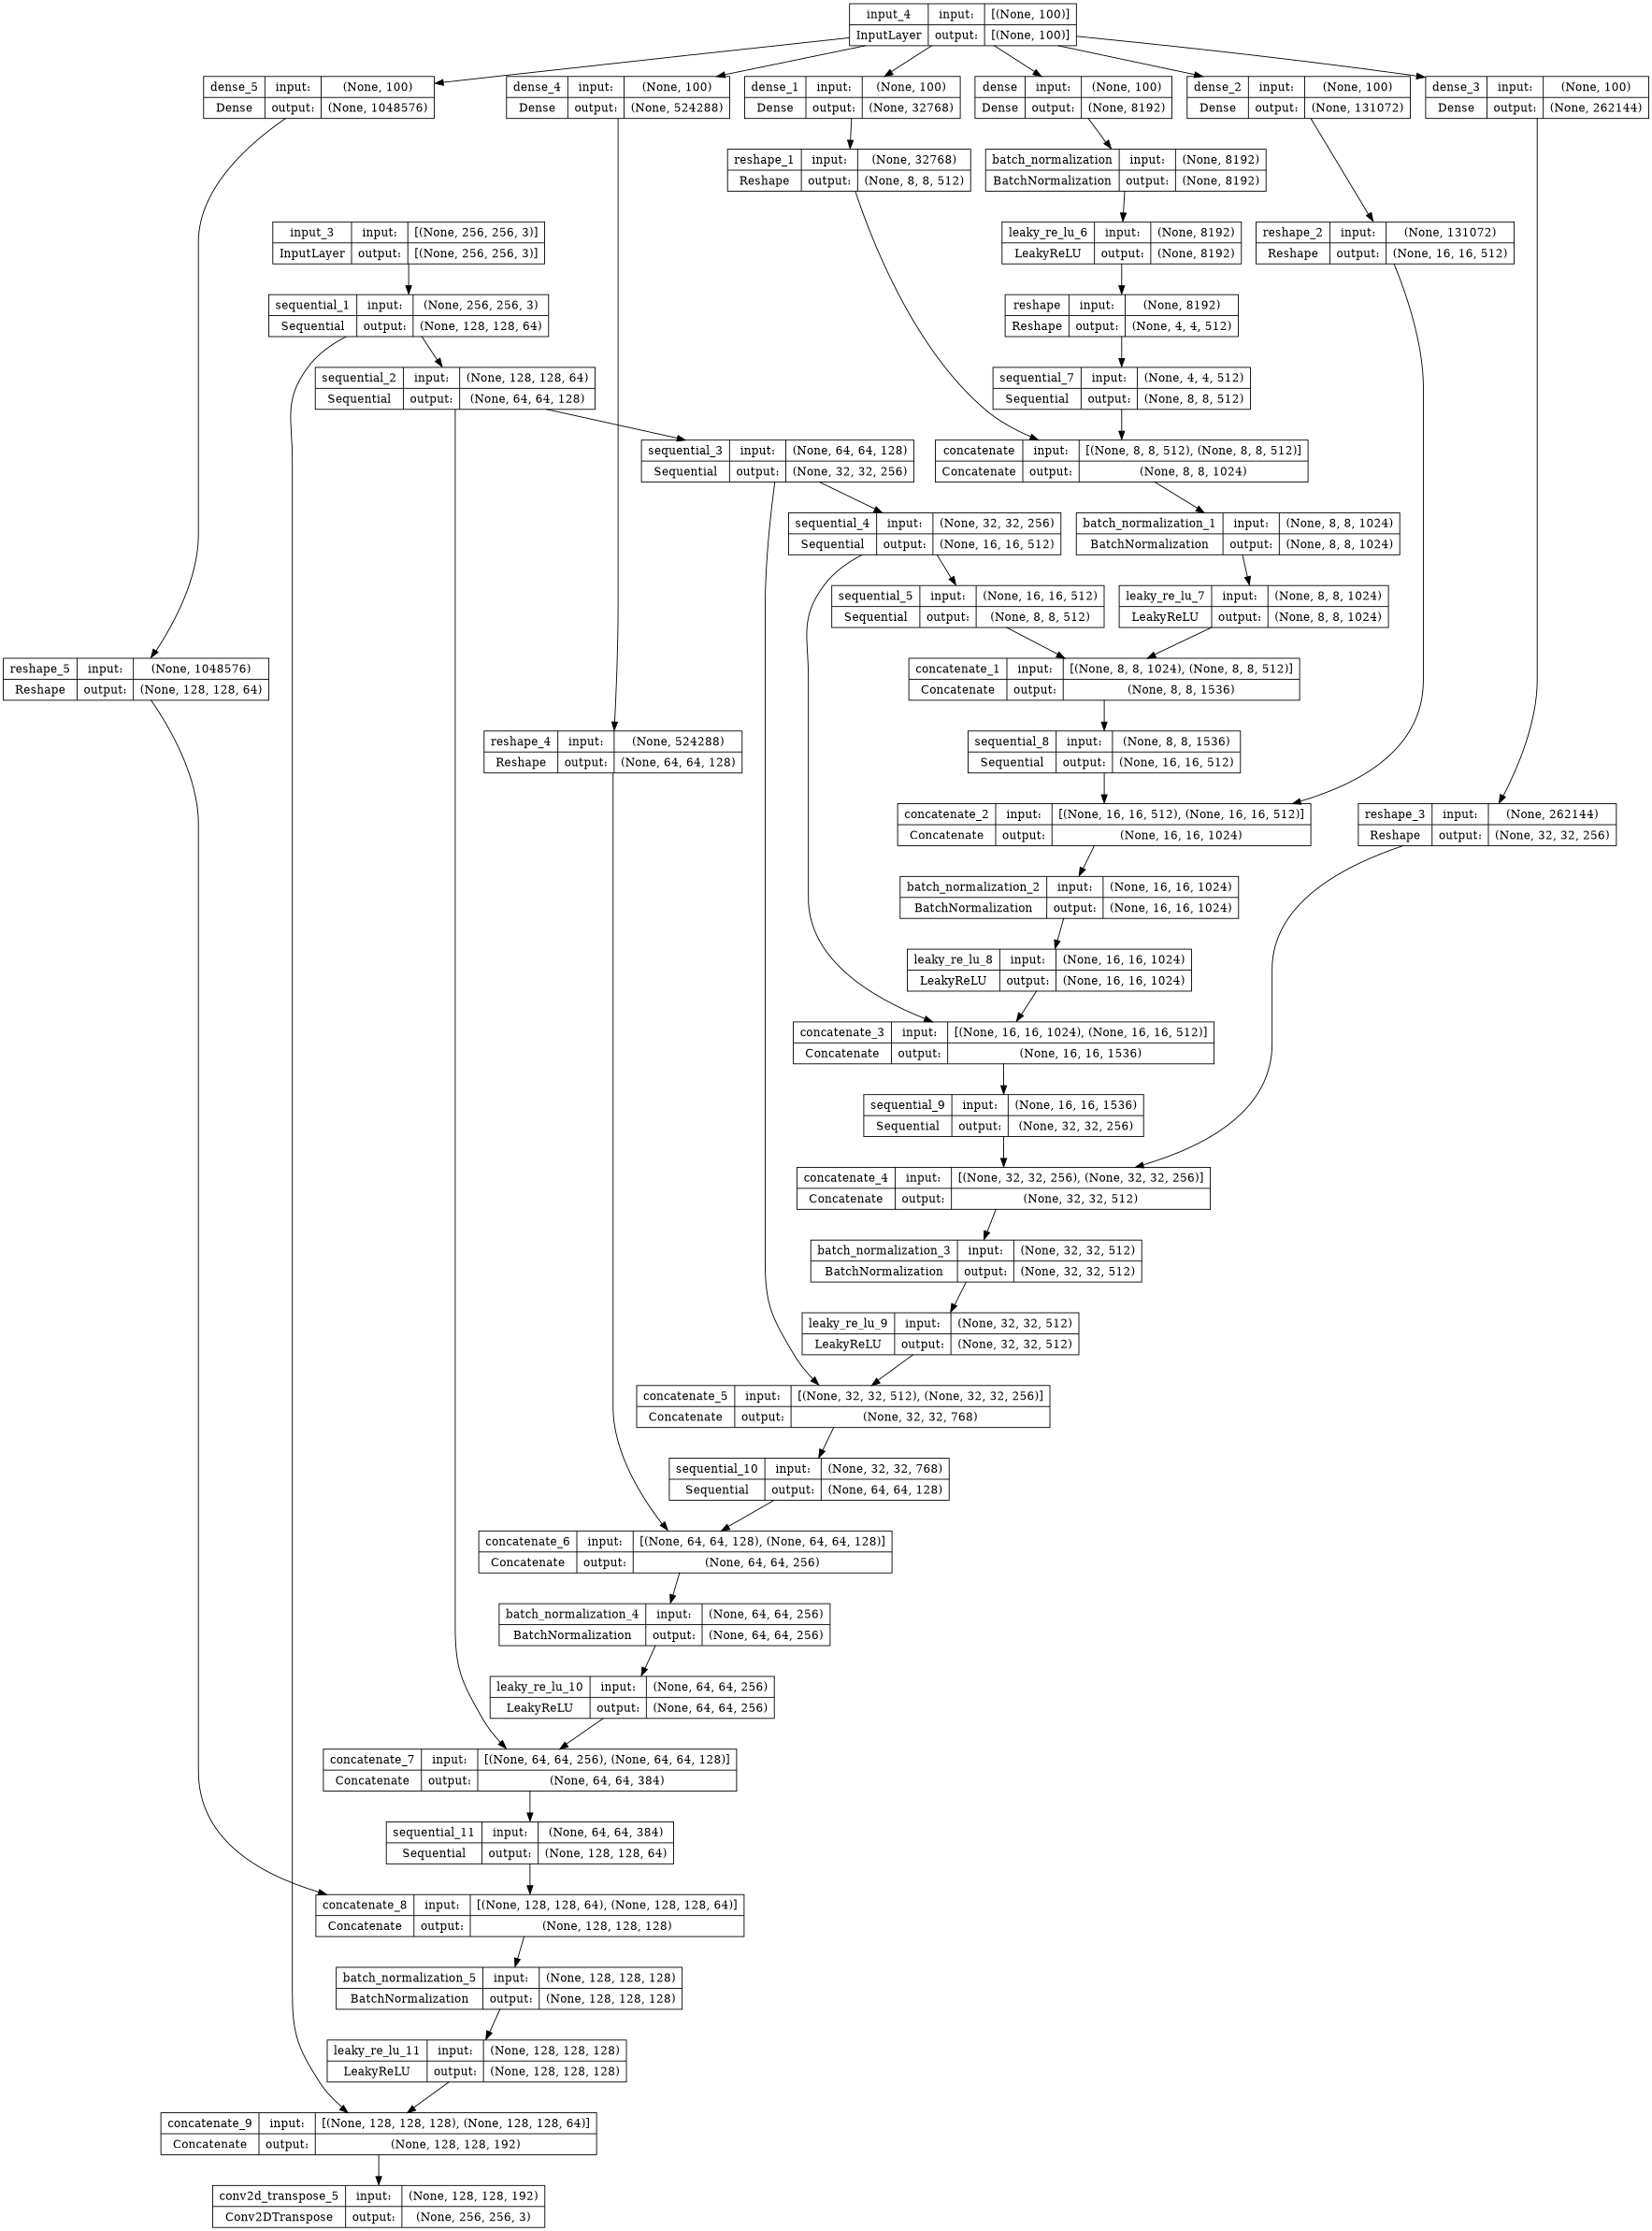

In [25]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [26]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    input_ = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    down1 = downsample(64, 3, 2,False)(input_)
    down2 = downsample(128, 3, 2)(down1)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
    conv = tf.keras.layers.Conv2D(256, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv) #Itfa.layers.InstanceNormalization()

    leaky_relu = tf.keras.layers.LeakyReLU(0.4)(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer,
                                )(zero_pad2)
    return tf.keras.Model(inputs=input_, outputs=last)

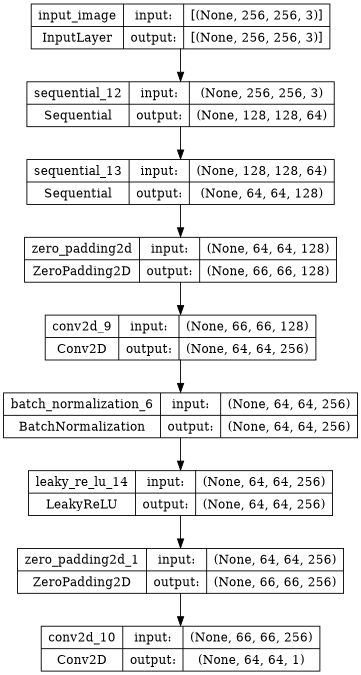

In [27]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [28]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + (generated_loss)*LAMBDA*0.5
    loss_ = (generated_loss)*LAMBDA*0.5
    
    return total_disc_loss, loss_

In [30]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA *(l1_loss)*0.5)

    return total_gen_loss, gan_loss, l1_loss

In [31]:
def reconstruction(recon_x, x):
    return tf.reduce_mean(tf.abs(recon_x - x))

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.99,epsilon=1e-08)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.99,epsilon=1e-08)

In [33]:
def generate_images(model, input_1, input_2, noise):
    prediction = model([input_1, noise], training=True)
    plt.figure(figsize=(15,15))

    display_list = [input_1[0], input_2[0], prediction[0]]
    title = ['Source Image', 'Destination Image', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

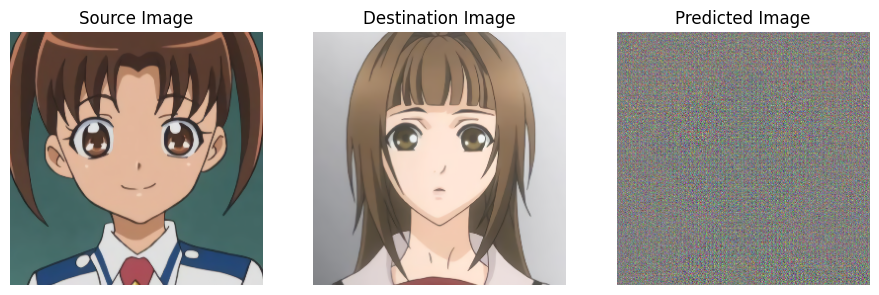

In [34]:
example_input_1 = next(iter(train_source))
example_input_2 = next(iter(train_dest))
noise = tf.random.normal([BATCH_SIZE, noise_dim])
generate_images(generator, example_input_1, example_input_2,noise)

In [35]:
@tf.function
def train_step(real_x, real_y, noise):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([real_x,noise], training=True)

        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, real_y)

        recon_loss = reconstruction(generated_images, real_x)
        disc_loss, _ = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  

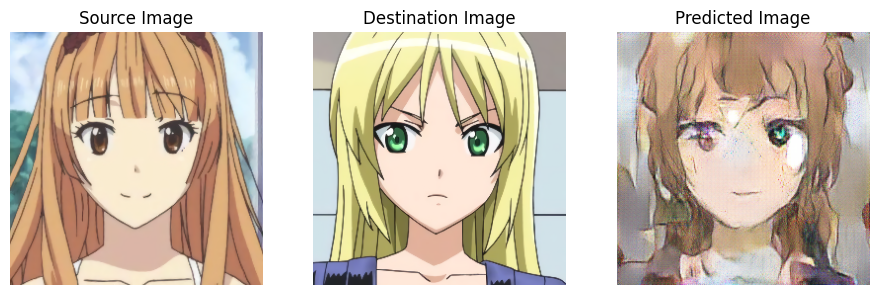

Time taken for epoch 1705 is 0.7339715957641602 sec



In [36]:
result=[]
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_source, train_dest)):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        train_step(image_x, image_y, noise)
        if n % 20 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    generate_images(generator, image_x, image_y, noise)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
    if epoch>=1600:
        pred = generator([image_x, noise], training=True)
        result.append(pred[0])

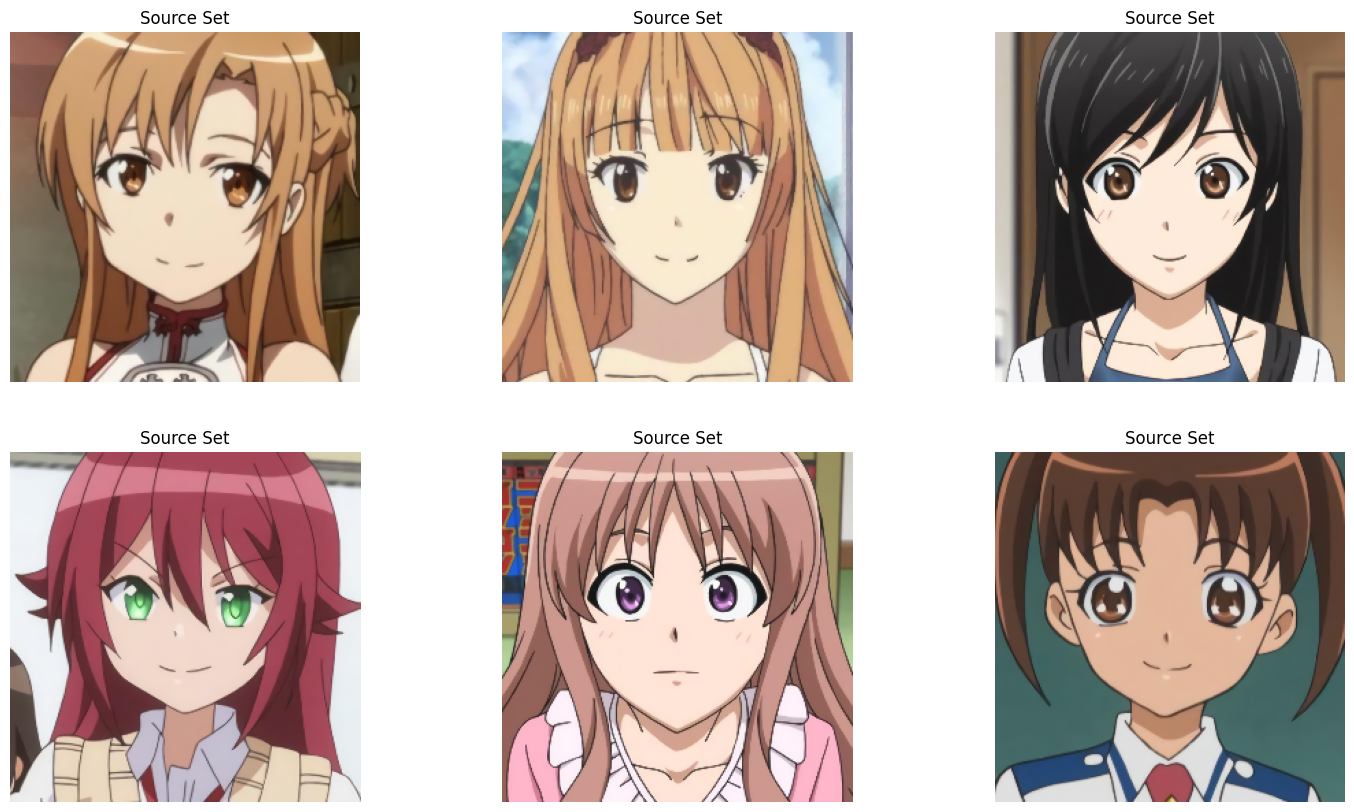

In [37]:
source = []
dest = []
for x,y in zip(ImageSet_1,ImageSet_2):
    source.append(load_image_train(x))
    dest.append(load_image_train(y))
fig, axis = plt.subplots(2, 3, figsize=(18, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(source[i] * 0.5 + 0.5)
    ax.set(title = f"Source Set")
    ax.axis('off')

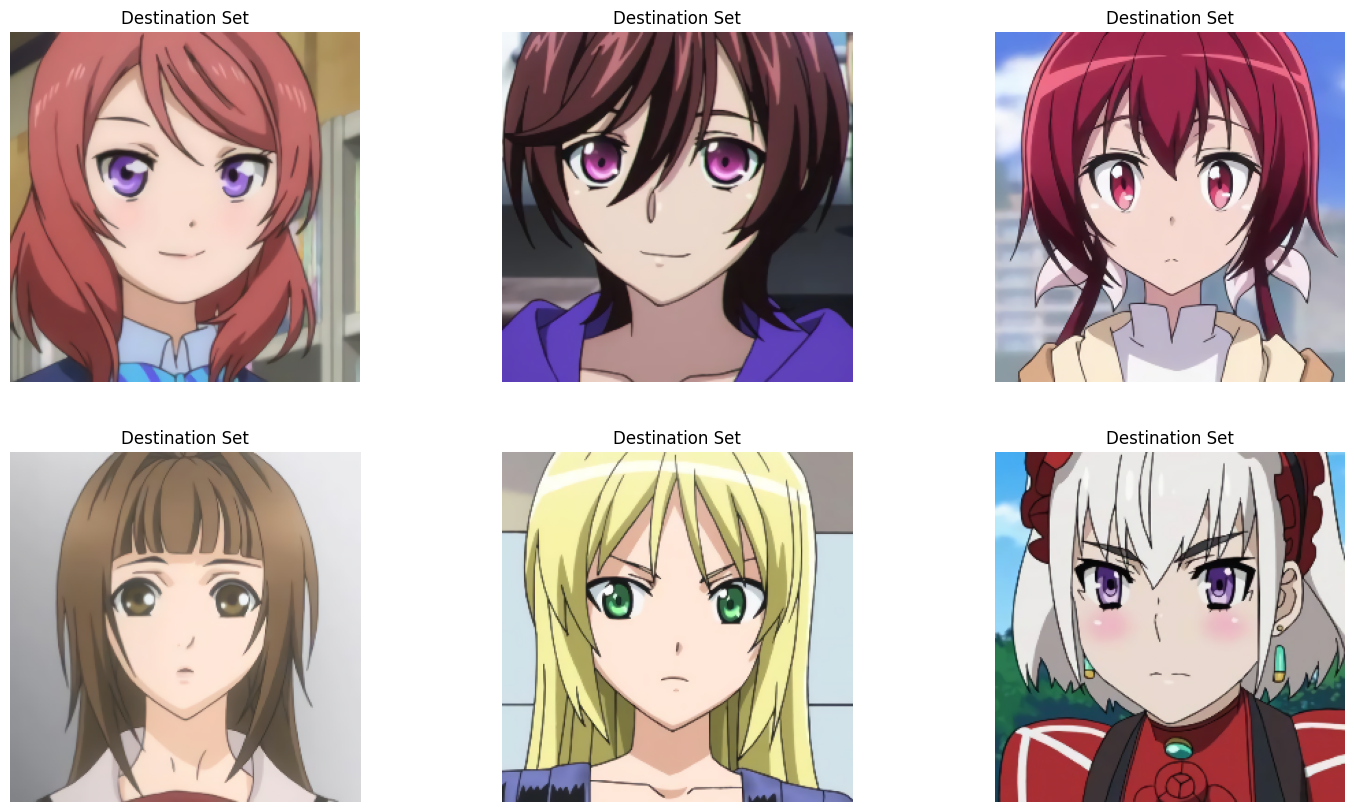

In [38]:
fig, axis = plt.subplots(2, 3, figsize=(18, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(dest[i] * 0.5 + 0.5)
    ax.set(title = f"Destination Set")
    ax.axis('off')

In [ ]:
res_1 = result[:15]
fig, axis = plt.subplots(5, 3, figsize=(25, 40))
for i, ax in enumerate(axis.flat):
    ax.imshow(res_1[i] * 0.5 + 0.5)
    ax.axis('off')